# 双技术指标：SMA+CCI交易系统

以SMA作为开仓信号，同时增加CCI作为过滤器
当股价上穿SMA，同时CCI要小于-100，说明是在超卖的情况，上穿SMA作为交易信号更可靠，做多
当股价下穿SMA，同时CCI要大于100，说明是在超买的情况，上穿SMA作为交易信号更可靠，做空

In [1]:
#导入需要的库
import numpy as np
import pandas as pd 
import tushare as ts
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import talib as ta
%matplotlib inline
# 确保‘-’显示正常
mpl.rcParams['axes.unicode_minus'] = False
# 确保中文正常显示
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
sns.set()

## 数据获取

In [6]:
#获取数据
stock_index = ts.get_k_data('hs300','2016-01-01','2017-06-30')
stock_index.set_index('date', inplace=True)
stock_index.head()

,open,close,high,low,volume,code
date,,,,,,
2016-01-04,3725.86,3470.41,3726.24,3469.01,115370674.0,hs300
2016-01-05,3382.18,3478.78,3518.22,3377.28,162116984.0,hs300
2016-01-06,3482.41,3539.81,3543.74,3468.47,145966144.0,hs300
2016-01-07,3481.15,3294.38,3481.15,3284.74,44102641.0,hs300
2016-01-08,3371.87,3361.56,3418.85,3237.93,185959451.0,hs300


In [7]:
# 计算指标SMA，CCI
stock_index['SMA'] = stock_index['close'].rolling(5).mean()
# stock_index['SMA'] = ta.SMA(np.asarray(stock_index['close']),5)
stock_index['CCI'] = ta.CCI(np.asarray(stock_index['high']), np.asarray(stock_index['low']), np.asarray(stock_index['close']),timeperiod=20)
# talib传递的是np.array

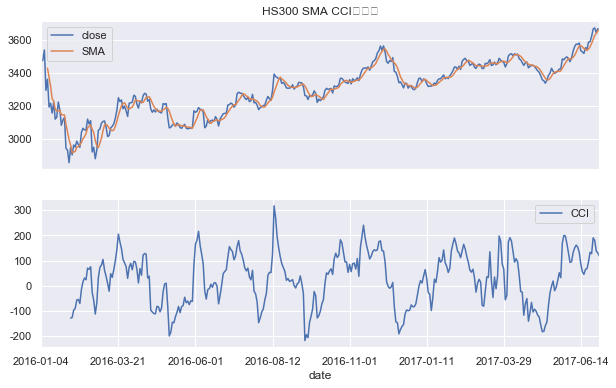

In [8]:
plt.subplot(2,1,1)
plt.title('HS300 SMA CCI指标图')
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize=(10,8))
stock_index['SMA'].plot(figsize=(10,8))
plt.legend()
plt.subplot(2,1,2)
stock_index['CCI'].plot(figsize=(10,6))
plt.legend()
# plt.show()

## 交易信号，持仓信号和策略逻辑

In [9]:
# 产生开仓信号时应使用昨日及前日数据，以避免未来数据
stock_index['yes_close'] = stock_index['close'].shift(1)
stock_index['yes_sma'] = stock_index['SMA'].shift(1)
stock_index['yes_cci'] = stock_index['CCI'].shift(1)
stock_index['daybefyes_close'] = stock_index['close'].shift(2)
stock_index['daybefyes_sma'] = stock_index['SMA'].shift(2)

In [10]:
# 产生交易信号 
#sma开多信号，昨日股价上穿sma
stock_index['sma_signal'] = np.where(np.logical_and((stock_index['daybefyes_close']<stock_index['daybefyes_sma']),
                                                (stock_index['yes_close']>stock_index['yes_sma'])), 1, 0)
#sma开少信号，昨日股价下穿sma
stock_index['sma_signal'] = np.where(np.logical_and((stock_index['daybefyes_close']>stock_index['daybefyes_sma']),
                                                (stock_index['yes_close']<stock_index['yes_sma'])), -1, stock_index['sma_signal'])
#产生cci做多过滤信号
stock_index['cci_filter'] = np.where(stock_index['yes_cci']<-100, 1, 0)
#产生cci做空过滤信号
stock_index['cci_filter'] = np.where(stock_index['yes_cci']>100, -1, stock_index['cci_filter'])

In [11]:
#过滤之后的开多信号
stock_index['filter_signal'] = np.where(stock_index['sma_signal']+stock_index['cci_filter'] == 2, 1, 0)
#过滤之后的开少信号
stock_index['filter_signal'] = np.where(stock_index['sma_signal']+stock_index['cci_filter'] ==-2, -1,stock_index['filter_signal'])
#生成交易信号
position = 0
for label, item in stock_index.iterrows():
    if item['filter_signal'] == 1:
        position =1
    elif item['filter_signal'] == -1:
        position = -1
    else:
        pass
    stock_index.loc[label, 'position'] = position
# #自动往下填充的就是上一个产生的交易信号,在position没有发生变化之前,一直填充之前的position

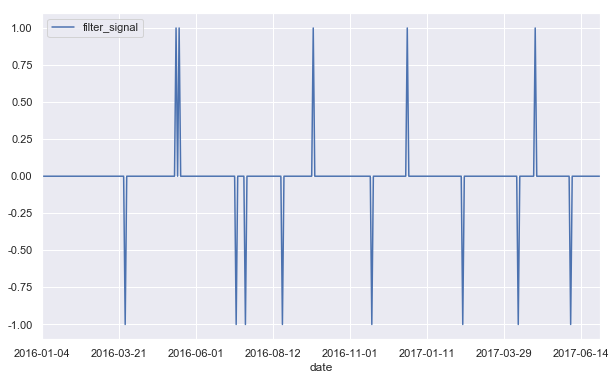

In [13]:
stock_index[['filter_signal']].plot(figsize=(10,6))

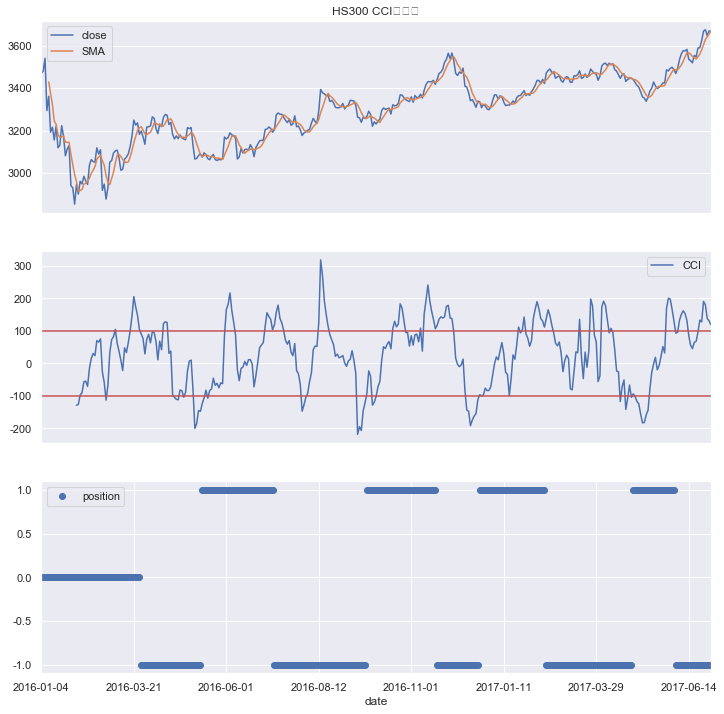

In [12]:
#画出持仓信号
plt.subplot(3,1,1)
plt.title('HS300 CCI持仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize=(10,10))
stock_index['SMA'].plot(figsize=(10,10))
plt.legend()
plt.subplot(3,1,2)
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['CCI'].plot(figsize=(10,6))
plt.axhline(100,color='r')
plt.axhline(-100,color='r')
plt.legend()
plt.subplot(3,1,3)
stock_index['position'].plot(marker='o', figsize=(12,12),linestyle='')
plt.legend()
# plt.show()

## 计算策略收益并可视化

In [14]:
# 计算股票每日收益
stock_index['pct_change'] = stock_index['close'].pct_change()
# 计算策略每日收益
stock_index['strategy'] = stock_index['pct_change'] * stock_index['position']
#计算股票累计收益
stock_index['return'] = (stock_index['pct_change']+1).cumprod()
#计算策略累计收益
stock_index['strategy_cum'] = (stock_index['strategy']+1).cumprod()

Text(0.5, 1.0, 'HS300 SMA CCI双指数策略收益图')

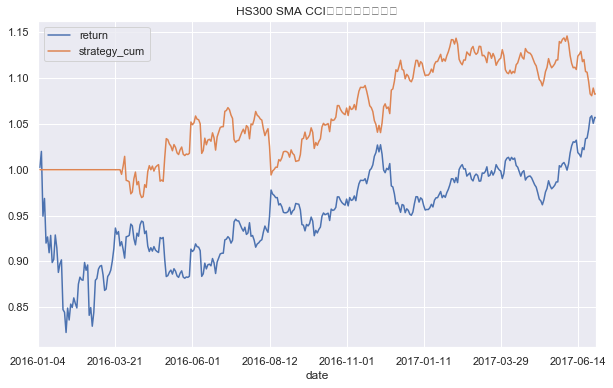

In [15]:
stock_index[['return','strategy_cum']].plot(figsize=(10,6))
plt.title('HS300 SMA CCI双指数策略收益图')